# Setup

## Library import
We import all the required Python libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import matplotlib.pyplot as plt

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

## Local library import
We import all the required local libraries libraries

In [2]:
# Include local library paths
import sys
# sys.path.append('path/to/local/lib') # uncomment and fill to import local libraries
import yfinance
import scipy.stats
# Import local libraries

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.


# Data import
We retrieve all the required data for the analysis.

In [3]:
first = pd.read_csv('INDEX.CSI300_120101_141231.csv', delimiter = ",")
second = pd.read_csv('INDEX.CSI300_150101_171231.csv', delimiter = ",")
third = pd.read_csv('INDEX.CSI300_180101_201231.csv', delimiter = ",")
fourth = pd.read_csv('INDEX.CSI300_210101_221128.csv', delimiter = ",")

In [4]:
data = pd.DataFrame()
for i in [first, second, third, fourth]:
    data = data.append(i, ignore_index = True)
display(data)

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,INDEX.CSI300,5,20120104,54500,2361.4990,2361.4990,2361.4990,2361.4990,245403
1,INDEX.CSI300,5,20120104,55000,2363.8790,2364.2060,2355.8910,2355.8910,2013863
2,INDEX.CSI300,5,20120104,55500,2355.7500,2358.2700,2355.3040,2358.0250,1148331
3,INDEX.CSI300,5,20120104,60000,2358.4710,2365.8240,2358.2800,2363.9270,1411218
4,INDEX.CSI300,5,20120104,60500,2364.4720,2365.9150,2361.3150,2361.3150,1345723
...,...,...,...,...,...,...,...,...,...
155829,INDEX.CSI300,5,20221128,105000,3733.2424,3733.2424,3733.2424,3733.2424,60
155830,INDEX.CSI300,5,20221128,105500,3733.2424,3733.2424,3733.2424,3733.2424,59
155831,INDEX.CSI300,5,20221128,110000,3733.2424,3733.2424,3733.2424,3733.2424,59
155832,INDEX.CSI300,5,20221128,110500,3733.2424,3733.2424,3733.2424,3733.2424,56


In [5]:
import datetime
def time_and_date (df):
    date = []
    only_date = []
    for row in df.iterrows():
        #print(row[1]['<TIME>'])
        date_obj = row[1]['<DATE>']
        time_obj = row[1]['<TIME>']
        #print((time_obj % 10000)//100)
        #days.append((date_obj % 10000) // 100)
        only_date.append(datetime.datetime(date_obj // 10000, (date_obj % 10000) // 100, date_obj % 100))
        date.append(datetime.datetime(date_obj // 10000, (date_obj % 10000) // 100, date_obj % 100, time_obj //10000, (time_obj % 10000)//100 ))
    df['Date'] = date
    df['Only_date'] = only_date

In [6]:
time_and_date(data)

In [7]:
data = data.drop(columns = [x for x in data.columns if x not in ['<CLOSE>', 'Date', 'Only_date']])
data = data.rename(columns = {'<CLOSE>': 'Close'})

In [8]:
data = data.drop(data.loc[data['Only_date'] > '2022-11-27'].index.to_list(), axis = 0)

In [9]:
display(data)

,Close,Date,Only_date
0,2361.4990,2012-01-04 05:45:00,2012-01-04
1,2355.8910,2012-01-04 05:50:00,2012-01-04
2,2358.0250,2012-01-04 05:55:00,2012-01-04
3,2363.9270,2012-01-04 06:00:00,2012-01-04
4,2361.3150,2012-01-04 06:05:00,2012-01-04
...,...,...,...
155765,3775.7764,2022-11-25 10:50:00,2022-11-25
155766,3775.7764,2022-11-25 10:55:00,2022-11-25
155767,3775.7764,2022-11-25 11:00:00,2022-11-25
155768,3775.7764,2022-11-25 11:05:00,2022-11-25


In [10]:
data['Date']

0        2012-01-04 05:45:00
1        2012-01-04 05:50:00
2        2012-01-04 05:55:00
3        2012-01-04 06:00:00
4        2012-01-04 06:05:00
                 ...        
155765   2022-11-25 10:50:00
155766   2022-11-25 10:55:00
155767   2022-11-25 11:00:00
155768   2022-11-25 11:05:00
155769   2022-11-25 11:10:00
Name: Date, Length: 155770, dtype: datetime64[ns]

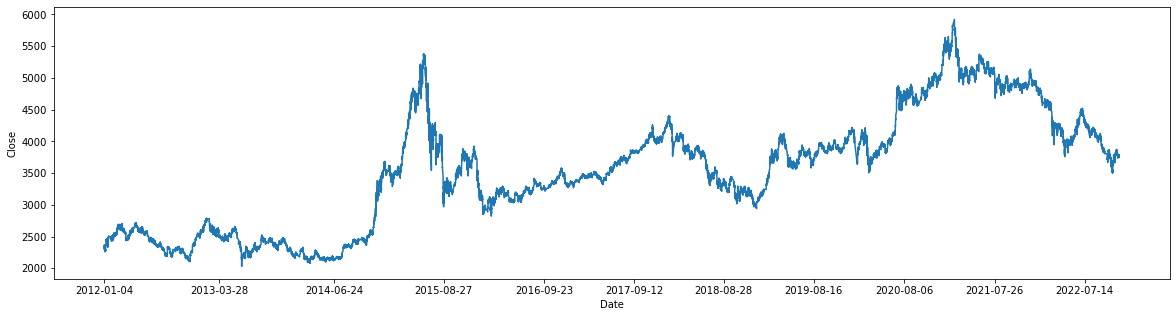

In [11]:
plt.figure(figsize = (20,5))
plt.plot(data['Date'], data['Close'])
plt.xticks(data['Date'][::15000])
plt.ylabel('Close')
plt.xlabel('Date')
plt.show()

# Data processing

In [12]:
#returns = data['Close'].pct_change().dropna()
returns = pd.DataFrame({
    'returns': data['Close'].pct_change().dropna(),
    'date': data['Date'][1:],
    'only_date': data['Only_date'][1:]
    
#    'rv': [x**2 for x in returns['returns']]
})
def realised_volatility(df):
    rv = []
    dates = []
    for date in df['only_date'].unique():
        _ = df.loc[df['only_date'] == date]
        rv.append(np.sum([x**2 for x in _['returns'].values]))
        dates.append(date)
    #= [x**2 for x in rv_per_day['returns']]
    new_df = pd.DataFrame({'rv': rv, 'date': dates})
    return new_df

In [13]:
rv_per_day = realised_volatility(returns)

In [14]:
returns = returns.drop(returns.loc[returns['only_date'] > '2022-11-27'].index.to_list(), axis = 0)
rv_per_day = rv_per_day.drop(rv_per_day.loc[rv_per_day['date'] > '2022-11-27'].index.to_list(), axis = 0)

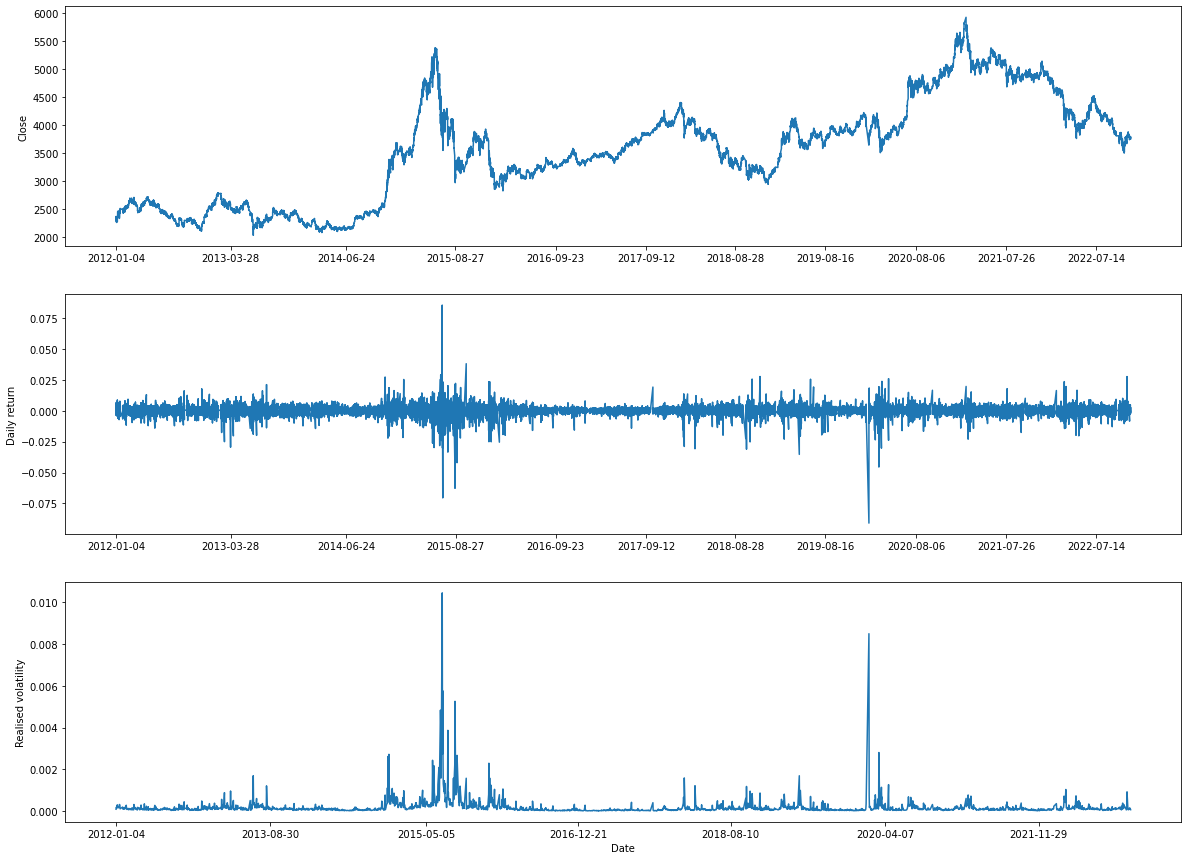

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))

ax[0].plot(data['Date'], data['Close'])
ax[0].set_xticks(data['Date'][::15000])
ax[0].set_ylabel('Close')
#ax.xlabel('Date')

ax[1].plot(returns['only_date'], returns['returns'])
ax[1].set_xticks(returns['only_date'][::15000])
ax[1].set_ylabel('Daily return')
#ax.xlabel('Date')

ax[2].plot(rv_per_day['date'], rv_per_day['rv'])
ax[2].set_xticks(rv_per_day['date'][::400])
ax[2].set_ylabel('Realised volatility')
ax[2].set_xlabel('Date')



plt.show()

C:\Users\dcher\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


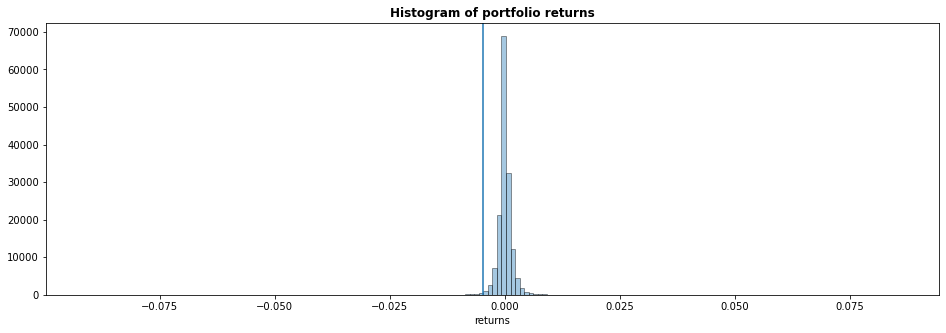

-0.004643794995011481


In [16]:
import seaborn as sns
fig = plt.figure(figsize=(16, 5))

sns.distplot(returns['returns'], hist=True, kde=False, 
             bins=180,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.axvline(np.quantile(returns['returns'], 0.01))
plt.title("Histogram of portfolio returns", weight="bold")

plt.show()
print(np.quantile(returns['returns'], 0.01))

In [17]:
from statsmodels.tsa.stattools import adfuller
data_characteristics = pd.DataFrame()
i = 0
#print(np.quantile(returns['returns'], 0.01))
for ind, dat in enumerate([returns['returns'].values, rv_per_day['rv'].values]):
    data_characteristics.loc[ind, 'mean'] = np.mean(dat)
    data_characteristics.loc[ind, 'var'] = np.var(dat)
    data_characteristics.loc[ind, 'skewness'] = scipy.stats.skew(dat)
    data_characteristics.loc[ind, 'kurtuosis'] = scipy.stats.kurtosis(dat)
    data_characteristics.loc[ind, 'Jarque-Bera'] = scipy.stats.jarque_bera(dat)[0]
    data_characteristics.loc[ind, 'ADF'] = adfuller(dat)[0]
    print(adfuller(dat))
    print(scipy.stats.jarque_bera(dat))


(-46.42862950713936, 0.0, 73, 155695, {'1%': -3.4303920013989955, '5%': -2.8615585640335004, '10%': -2.566779880972682}, -1535341.4049333697)
Jarque_beraResult(statistic=143249825.24450633, pvalue=0.0)
(-5.598227450391796, 1.2824026327133447e-06, 28, 2613, {'1%': -3.432855065314769, '5%': -2.8626467455889886, '10%': -2.567359159973045}, -34498.27034196881)
Jarque_beraResult(statistic=4838983.8632743005, pvalue=0.0)


In [18]:
data_characteristics

,mean,var,skewness,kurtuosis,Jarque-Bera,ADF
0,0.000005,3.061411e-06,-1.566083,148.530490,1.432498e+08,-46.428630
1,0.000180,1.879156e-07,12.036283,208.273793,4.838984e+06,-5.598227


So, we can say that our data is not a stationary timeseries and don`t have normal distribution

In [19]:
del first
del second
del third
del fourth

# Models

In [59]:
def RV(df_rv, t, i):
    #print(t - datetime.timedelta(i))
    #print(df_rv.loc[df_rv['date'] == t - datetime.timedelta(days = i)]['rv'].values[0])
    if len(df_rv.loc[df_rv['date'] == t - datetime.timedelta(days=i)]['rv'].values) != 0:
        return df_rv.loc[df_rv['date'] == t -
                         datetime.timedelta(days=i)]['rv'].values[0]
    else:
        return 0
    #return df_rv.loc[df_rv['date'] == t - datetime.timedelta(days = i)]['rv'].values[0]  #[x**2 for x in df_r.loc[df_r['only_date'] == t - datetime.timedelta(i)]['returns'].values])


def RV_tj(df_rv, t, j, h):
    return (1 /
            (h + 1 - j)) * np.sum([RV(df_rv, t, i) for i in range(j, h + 1)])


def HAR(df_r, df_rv):
    HAR_data = pd.DataFrame()
    for ind, x in enumerate(df_rv.iterrows()):
        if ind > 21:
            #print(x[1]['date'])
            HAR_data.loc[ind - 22, 'date'] = x[1]['date']
            HAR_data.loc[ind - 22, 'day'] = df_rv['rv'][ind - 1]
            HAR_data.loc[ind - 22, 'week'] = RV_tj(df_rv, x[1]['date'], 1, 5)
            HAR_data.loc[ind - 22, 'month'] = RV_tj(df_rv, x[1]['date'], 1, 22)
            HAR_data.loc[ind - 22, 'rv'] = df_rv['rv'][ind]
            #HAR_data.loc[ind,
            #             'cvartaly'] = np.sum(rv['returns'][ind - 66:ind]) / 66
    return HAR_data


def HAR_j(df_r, df_rv):
    HAR_data = pd.DataFrame()
    for ind, x in enumerate(df_rv.iterrows()):
        if ind > 21:
            HAR_data.loc[ind - 22, 'date'] = x[1]['date']
            HAR_data.loc[ind - 22, 'day'] = df_rv['rv'][ind - 1]
            HAR_data.loc[ind - 22, 'week'] = RV_tj(df_rv, x[1]['date'], 1, 5)
            HAR_data.loc[ind - 22, 'month'] = RV_tj(df_rv, x[1]['date'], 1, 22)
            HAR_data.loc[ind - 22, 'jump'] = max(
                0, df_rv['rv'][ind] - (np.pi / 2) * np.sum([
                    df_r.iloc[i - 1]['returns'] * df_r.iloc[i]['returns']
                    for i in df_r.loc[df_r['only_date'] == x[1]
                                      ['date'] - datetime.timedelta(days=1)].index.to_list()[:-1]
                ]))
            HAR_data.loc[ind - 22, 'rv'] = df_rv['rv'][ind]
    return HAR_data


def BPV(df_r, t, i):
    return (np.pi / 2) * np.sum([
        df_r.iloc[row - 1]['returns'] * df_r.iloc[row]['returns']
        for row in df_r.loc[df_r['only_date'] == t -
                          datetime.timedelta(days=i)].index.to_list()[:-1]
    ])


def BPV_tj(df_r, t, j, h):
    return (1 /
            (h - j + 1)) * np.sum([BPV(df_r, t, i) for i in range(j, h + 1)])


def CHAR(df_r, df_rv):
    HAR_data = pd.DataFrame()
    for ind, x in enumerate(df_rv.iterrows()):
        if ind > 21:
            #print(x[1]['date'])
            HAR_data.loc[ind-22, 'date'] = x[1]['date']
            #print(BPV(df_r, x[1]['date'], 1))
            HAR_data.loc[ind-22, 'daily'] = BPV(df_r, x[1]['date'], 1)
            HAR_data.loc[ind-22, 'week'] = BPV_tj(df_r, x[1]['date'], 1, 5)
            HAR_data.loc[ind-22, 'month'] = BPV_tj(df_r, x[1]['date'], 1, 22)
            HAR_data.loc[ind-22, 'rv'] = df_rv['rv'][ind]
            sys.stdout.write('\r' + ' ' * 50 + '\r')  # Очищение строки
            sys.stdout.write(f'{(ind+1)/df_rv.shape[0]}')
            sys.stdout.flush()
    return HAR_data


def SHAR(df_r, df_rv):
    HAR_data = pd.DataFrame()
    for ind, x in enumerate(df_rv.iterrows()):
        if ind > 21:
            #print(x[1]['date'])
            HAR_data.loc[ind-22, 'date'] = x[1]['date']
            #print(x[1]['returns'])
            ret_positive = []
            ret_negative = []
            for ret in df_r.loc[df_r['only_date'] == x[1]
                                ['date']]['returns'].values:
                if ret > 0:
                    ret_positive.append(ret**2)
                else:
                    ret_negative.append(ret**2)
            HAR_data.loc[ind-22,
                         'day+'] = np.sum(ret_positive) / len(ret_positive)
            HAR_data.loc[ind-22,
                         'day-'] = np.sum(ret_negative) / len(ret_negative)
            HAR_data.loc[ind-22, 'week'] = RV_tj(df_rv, x[1]['date'], 1, 5)
            HAR_data.loc[ind-22, 'month'] = RV_tj(df_rv, x[1]['date'], 1, 22)
            HAR_data.loc[ind-22, 'rv'] = df_rv['rv'][ind]
    return HAR_data


def RQ(df_r, t, i):
    #data = df_r.loc[df_r['only_date'] == t -
    #                datetime.timedelta(days=i)].reset_index(drop=True)
    #print(data)
    #print('  ')
    #print([(data['returns'][i]) ** 4 for i in range(data.shape[0])])
    return (data.shape[0] / 3 * np.sum([(df_r['returns'][r-1])**4
                                       for r in df_r.loc[df_r['only_date'] == t -
                    datetime.timedelta(days=i)].index.to_list()[:-1]])) ** (1/2)


def HARQ(df_r, df_rv):
    HAR_data = pd.DataFrame()
    for ind, x in enumerate(df_rv.iterrows()):
        if ind > 21:
            #print(x[1]['date'])
            HAR_data.loc[ind-22, 'date'] = x[1]['date']
            HAR_data.loc[ind-22, 'RQ^1/2'] = RQ(df_r, x[1]['date'],
                                             1) #* df_rv['rv'][ind - 1]
            HAR_data.loc[ind-22, 'day'] = df_rv['rv'][ind - 1]
            HAR_data.loc[ind-22, 'week'] = RV_tj(df_rv, x[1]['date'], 1, 5)
            HAR_data.loc[ind-22, 'month'] = RV_tj(df_rv, x[1]['date'], 1, 22)
            HAR_data.loc[ind-22, 'rv'] = df_rv['rv'][ind]
    return HAR_data


def RQ_tj(df_r, t, j, h):
    return (1 /
            (h + 1 - j)) * np.sum([RQ(df_r, t, i) for i in range(j, h + 1)])


def HARQF(df_r, df_rv):
    HAR_data = pd.DataFrame()
    for ind, x in enumerate(df_rv.iterrows()):
        if ind > 21:
            #print(x[1]['date'])
            HAR_data.loc[ind-22, 'date'] = x[1]['date']
            HAR_data.loc[ind-22, 'day'] = df_rv['rv'][ind - 1]
            HAR_data.loc[ind-22, 'day_RQ^1/2'] = RQ(df_r, x[1]['date'],
                                             1) * df_rv['rv'][ind - 1]
            HAR_data.loc[ind-22, 'week'] = RV_tj(df_rv, x[1]['date'], 1, 5)
            HAR_data.loc[ind-22, 'week_RQ^1/2'] = RQ_tj(
                df_r, x[1]['date'], 1, 5) * RV_tj(df_rv, x[1]['date'], 1, 5)
            HAR_data.loc[ind-22, 'month'] = RV_tj(df_rv, x[1]['date'], 1, 22)
            HAR_data.loc[ind-22, 'month_RQ^1/2'] = RQ_tj(
                df_r, x[1]['date'], 1, 22) * RV_tj(df_rv, x[1]['date'], 1, 22)
            HAR_data.loc[ind-22, 'rv'] = df_rv['rv'][ind]
    return HAR_data

In [63]:
df_HAR = HAR(returns, rv_per_day)
print(1)
df_HAR_j = HAR_j(returns, rv_per_day)
print(2)
df_CHAR = CHAR(returns, rv_per_day)
print(3)
df_SHAR = SHAR(returns, rv_per_day)
print(4)
df_HARQ = HARQ(returns, rv_per_day)
print(5)
df_HARQF = HARQF(returns, rv_per_day)

1
2
1.0                                               3
4
5


# Try models

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

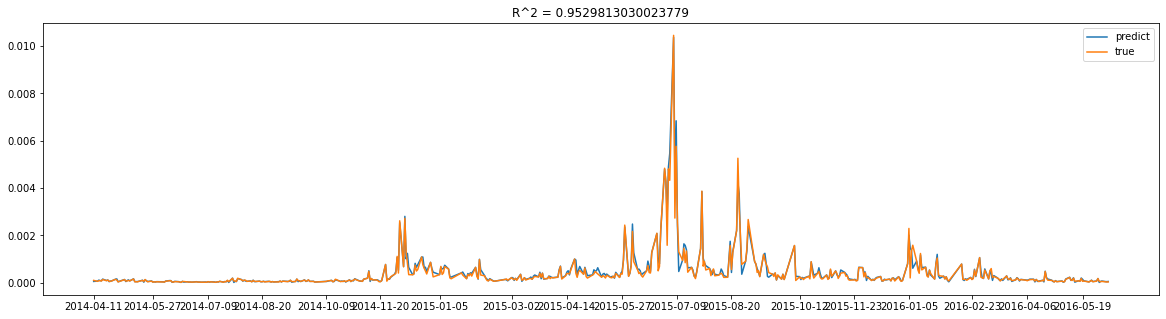

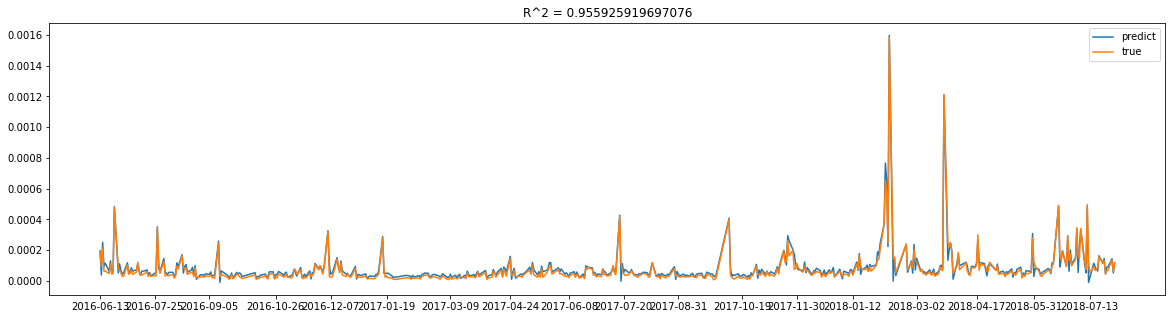

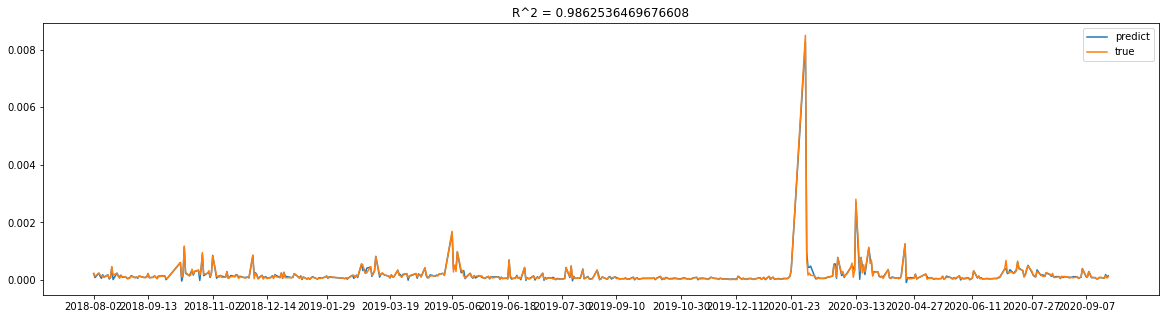

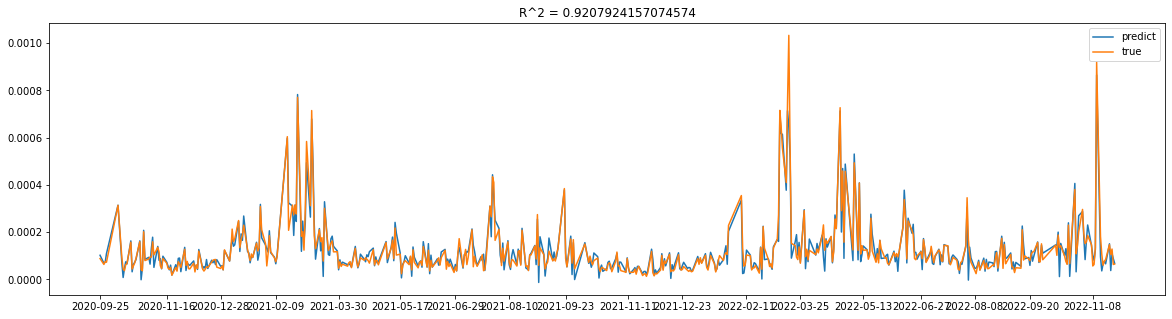

In [39]:
df = HAR_j(returns, rv_per_day)
features = [x for x in df.columns if (x != 'rv') & (x != 'date')]
target = ['rv']
tscv = TimeSeriesSplit(n_splits = 4)
for train_index, test_index in tscv.split(df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    X_train = cv_train[features]
    y_train = cv_train[target]
    X_test = cv_test[features]
    y_test = cv_test[target]
    reg = LinearRegression().fit(X_train, y_train)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(cv_test['date'],reg.predict(X_test), label = 'predict')
    ax.plot(cv_test['date'],y_test, label = 'true')
    ax.set_xticks(cv_test['date'][::30])
    #text = str('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.set_title('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.legend()
    plt.show()


{'daily': 0.22537282897529692,
 'week': 0.9896804712338363,
 'month': 2.461515872235869}

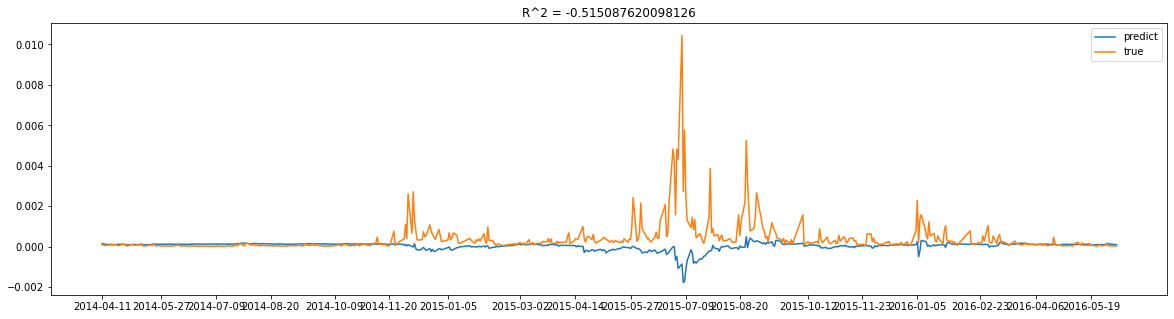

{'daily': 0.7244917431422557,
 'week': -3.7194313392484775,
 'month': -4.557547334225214}

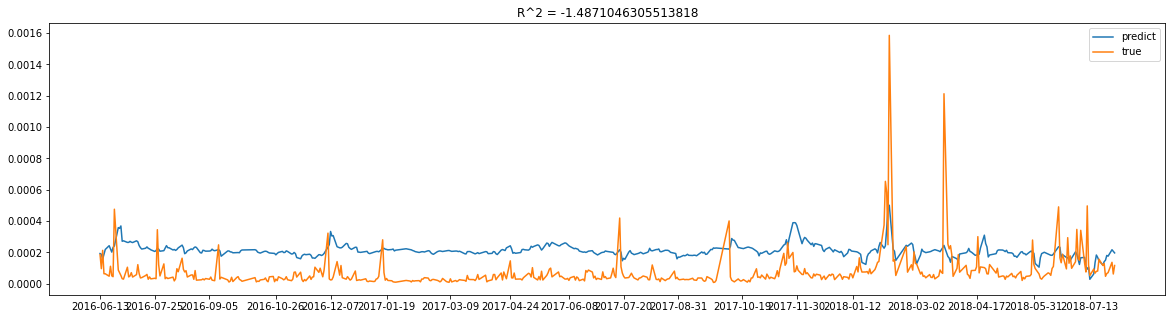

{'daily': 0.7155028860533152,
 'week': -3.7260313588611176,
 'month': -4.751696728662361}

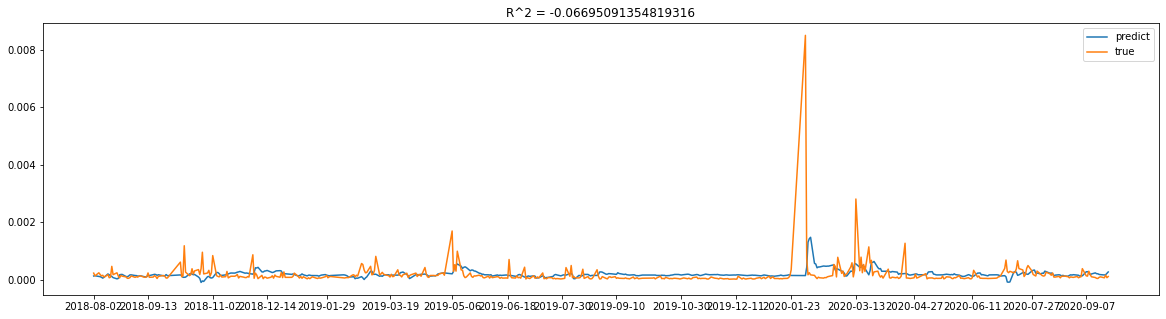

{'daily': 0.6255453971179356,
 'week': -3.3745010832663764,
 'month': -4.5704970217736065}

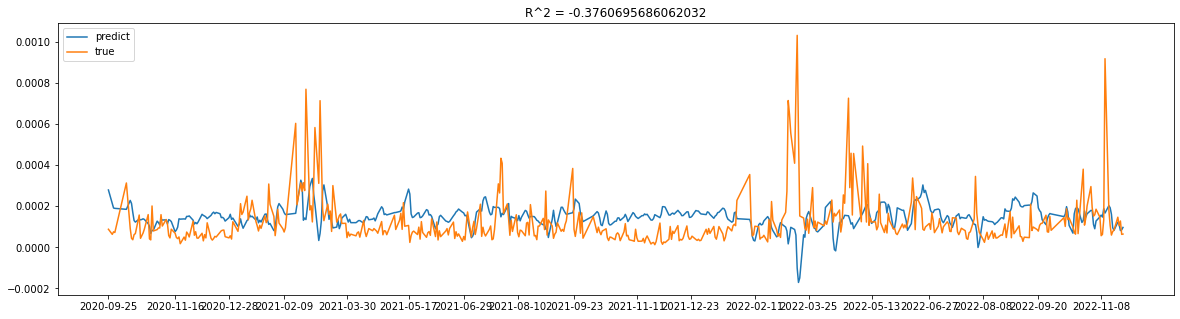

In [29]:
#df = CHAR(returns, rv_per_day)
df = df_CHAR
features = [x for x in df.columns if (x != 'rv') & (x != 'date')]
target = ['rv']
tscv = TimeSeriesSplit(n_splits = 4)
for train_index, test_index in tscv.split(df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    X_train = cv_train[features]
    y_train = cv_train[target]
    X_test = cv_test[features]
    y_test = cv_test[target]
    reg = LinearRegression().fit(X_train, y_train)
    coefficents = {}
    coef = reg.coef_[0]
    for ind, x in enumerate([x for x in coef]):
        coefficents[features[ind]] = x
    display(coefficents)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(cv_test['date'],reg.predict(X_test), label = 'predict')
    ax.plot(cv_test['date'],y_test, label = 'true')
    ax.set_xticks(cv_test['date'][::30])
    #text = str('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.set_title('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.legend()
    plt.show()

## Smth wrong with CHAR, need more time to understand what I do wrong.

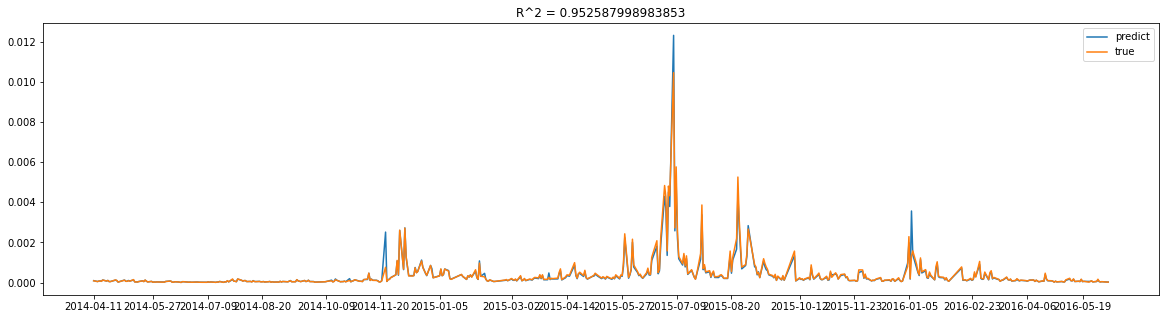

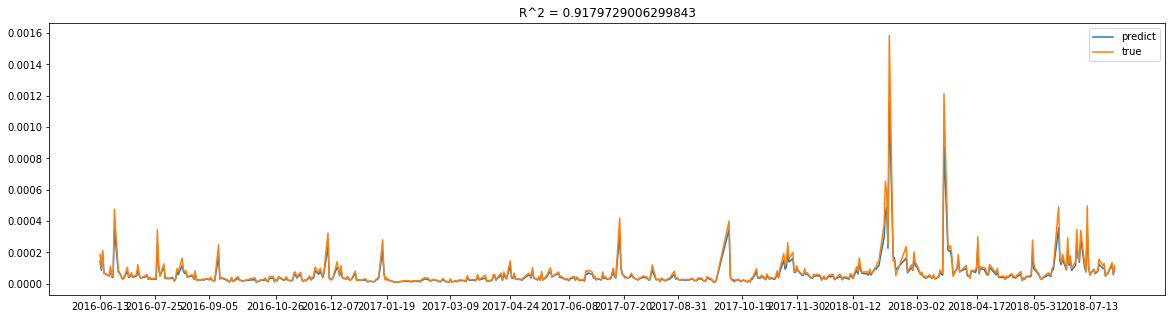

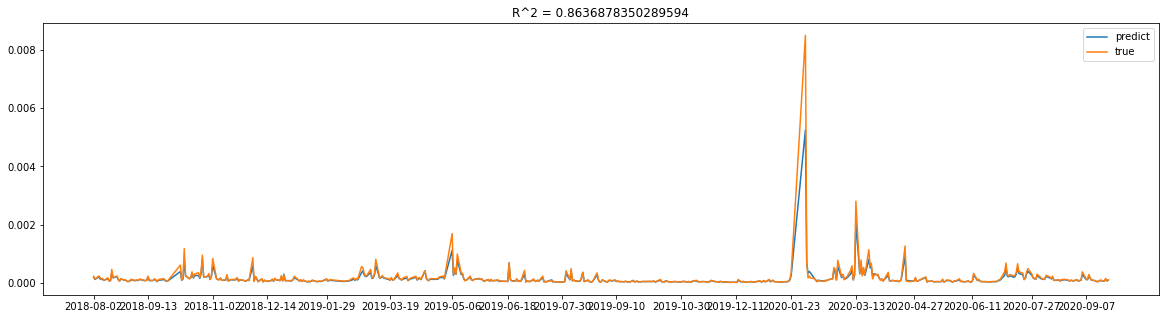

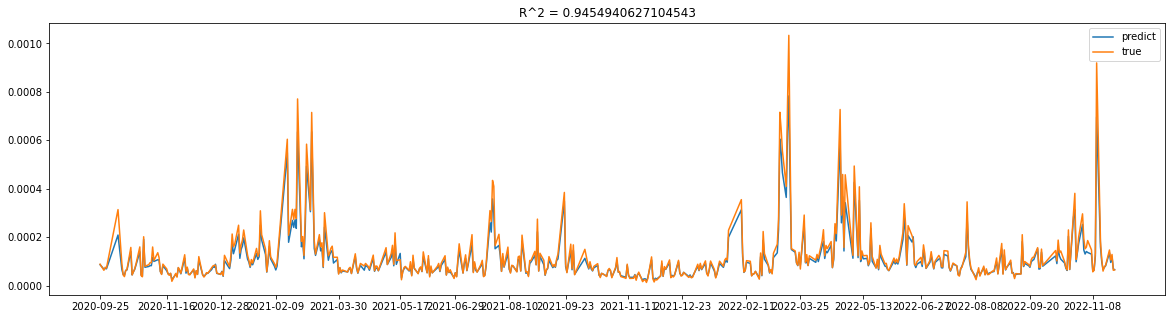

In [354]:
df = SHAR(returns, rv_per_day)
features = [x for x in df.columns if (x != 'rv') & (x != 'date')]
target = ['rv']
tscv = TimeSeriesSplit(n_splits = 4)
for train_index, test_index in tscv.split(df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    X_train = cv_train[features]
    y_train = cv_train[target]
    X_test = cv_test[features]
    y_test = cv_test[target]
    reg = LinearRegression().fit(X_train, y_train)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(cv_test['date'],reg.predict(X_test), label = 'predict')
    ax.plot(cv_test['date'],y_test, label = 'true')
    ax.set_xticks(cv_test['date'][::30])
    #text = str('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.set_title('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.legend()
    plt.show()

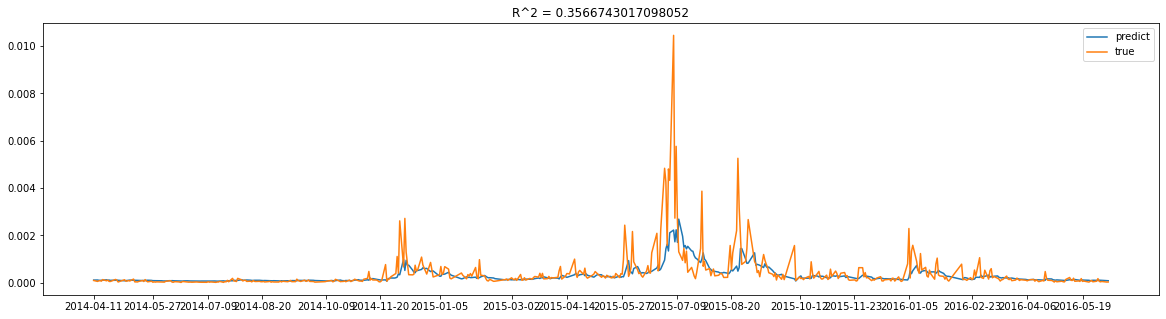

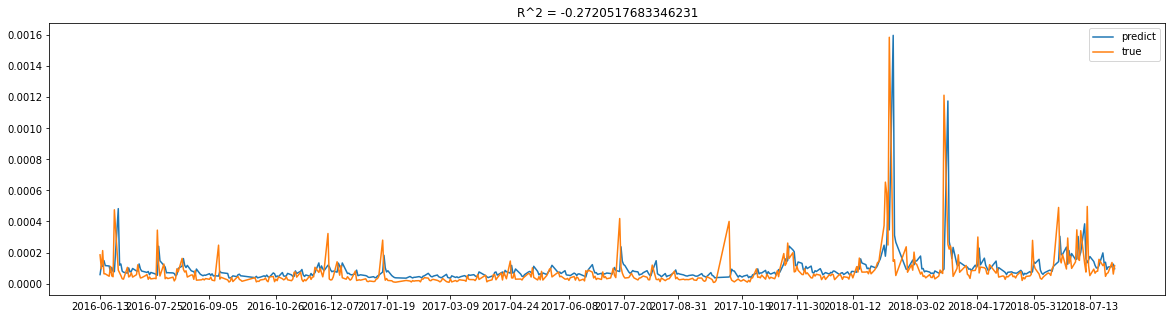

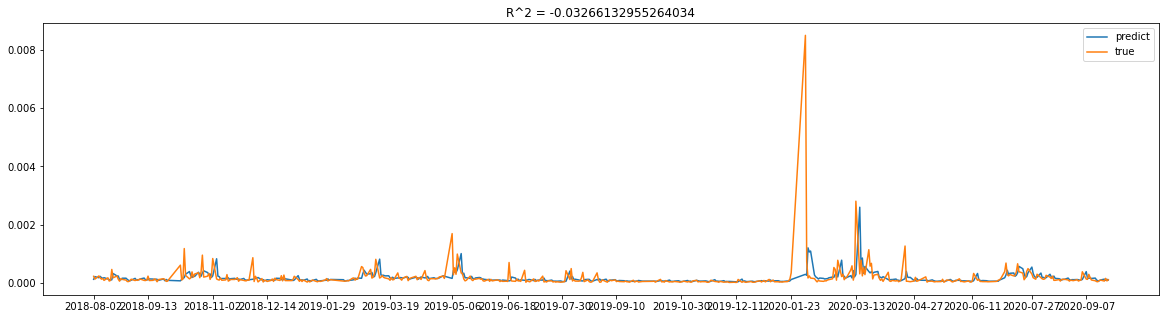

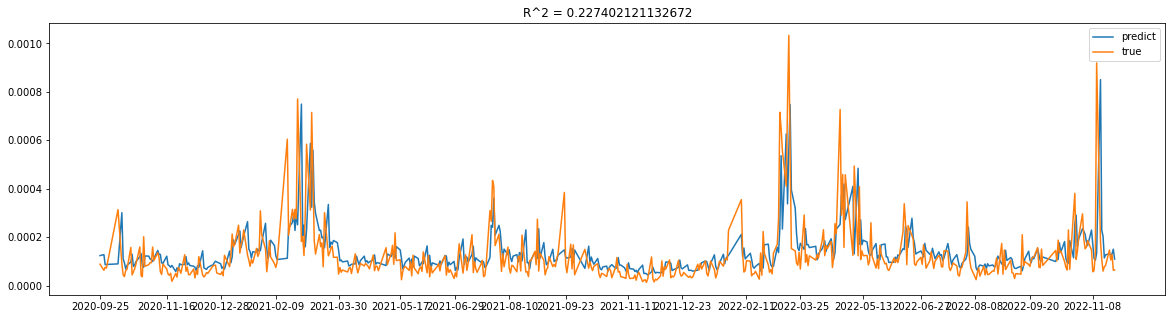

In [60]:
df = HARQ(returns, rv_per_day)
features = [x for x in df.columns if (x != 'rv') & (x != 'date')]
target = ['rv']
tscv = TimeSeriesSplit(n_splits = 4)
for train_index, test_index in tscv.split(df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    X_train = cv_train[features]
    y_train = cv_train[target]
    X_test = cv_test[features]
    y_test = cv_test[target]
    reg = LinearRegression().fit(X_train, y_train)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(cv_test['date'],reg.predict(X_test), label = 'predict')
    ax.plot(cv_test['date'],y_test, label = 'true')
    ax.set_xticks(cv_test['date'][::30])
    #text = str('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.set_title('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.legend()
    plt.show()

['day', 'day_RQ^1/2', 'week', 'week_RQ^1/2', 'month', 'month_RQ^1/2']


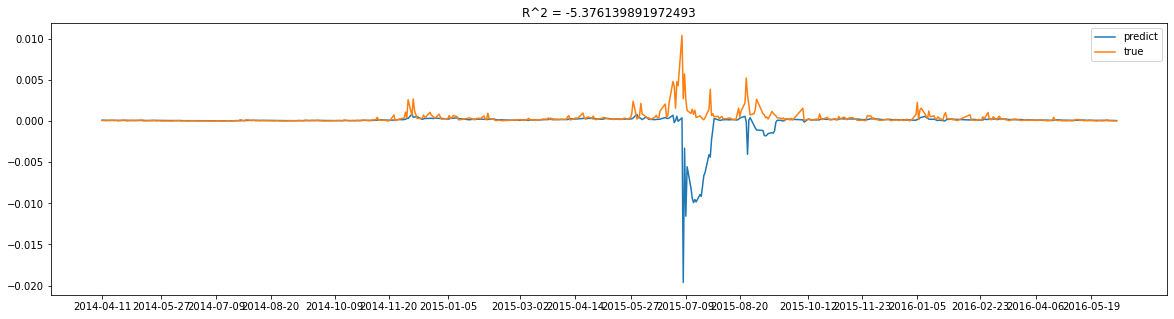

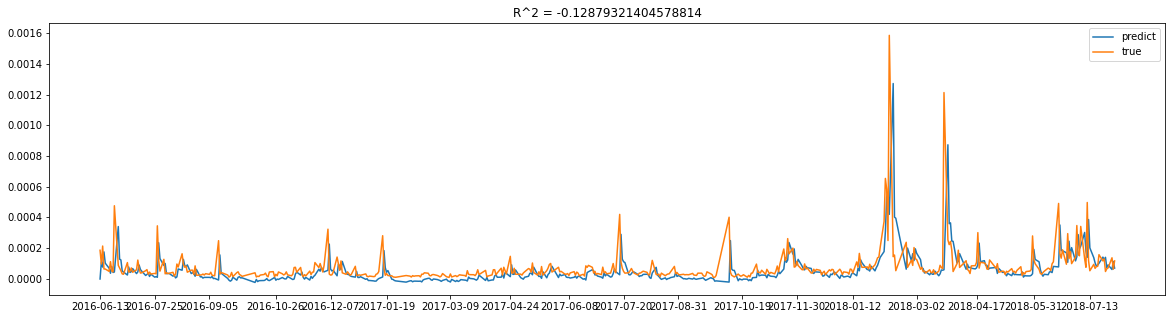

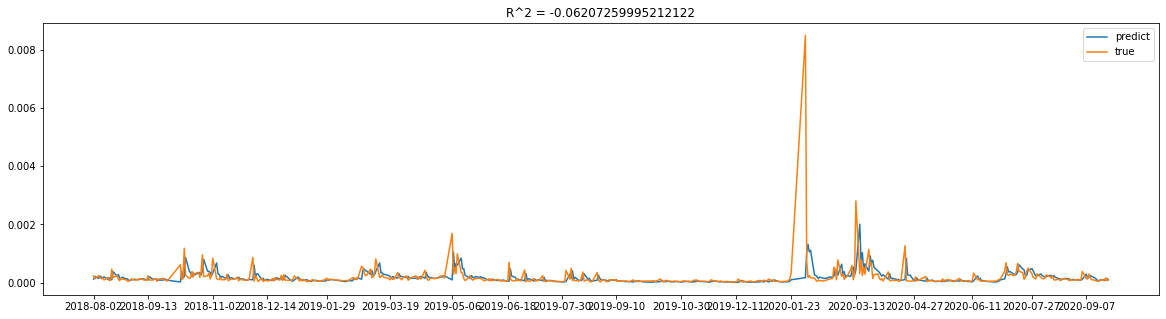

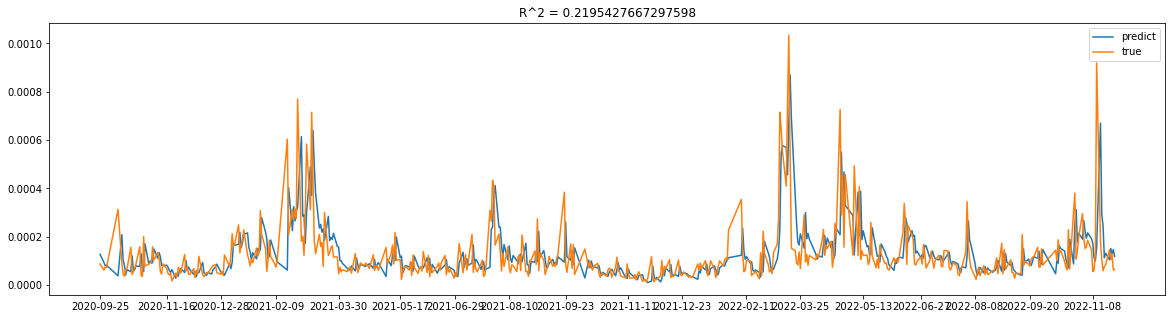

In [61]:
df = HARQF(returns, rv_per_day)
features = [x for x in df.columns if (x != 'rv') & (x != 'date')]
print(features)
target = ['rv']
tscv = TimeSeriesSplit(n_splits = 4)
for train_index, test_index in tscv.split(df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    X_train = cv_train[features]
    y_train = cv_train[target]
    X_test = cv_test[features]
    y_test = cv_test[target]
    reg = LinearRegression().fit(X_train, y_train)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(cv_test['date'],reg.predict(X_test), label = 'predict')
    ax.plot(cv_test['date'],y_test, label = 'true')
    ax.set_xticks(cv_test['date'][::30])
    #text = str('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.set_title('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.legend()
    plt.show()

# All models in one & train set - $\frac{9}{10}$ of all data

{'day': 0.2670882123178876,
 'week': 0.47048584187087145,
 'month': 0.3243292242356256}

{'day': -0.12155406310458348,
 'week': 0.07393518876334938,
 'month': -0.006987332112684852,
 'jump': 0.9867014886147468}

{'daily': 0.6145593626131354,
 'week': -3.308048665823006,
 'month': -4.643563160671585}

{'day+': 19.06172635827386,
 'day-': 32.11619936750908,
 'week': 0.02761689010355628,
 'month': 0.02023543829828425}

{'RQ^1/2': -0.00351867804393287,
 'day': 0.7695118702349386,
 'week': 0.3684443612694514,
 'month': 0.18959263597979187}

{'day': 0.5303274895421396,
 'day_RQ^1/2': -0.26531361754260213,
 'week': 0.6304120707628906,
 'week_RQ^1/2': -0.6587904364985032,
 'month': 0.39995077320863526,
 'month_RQ^1/2': -1.4301326499462708}

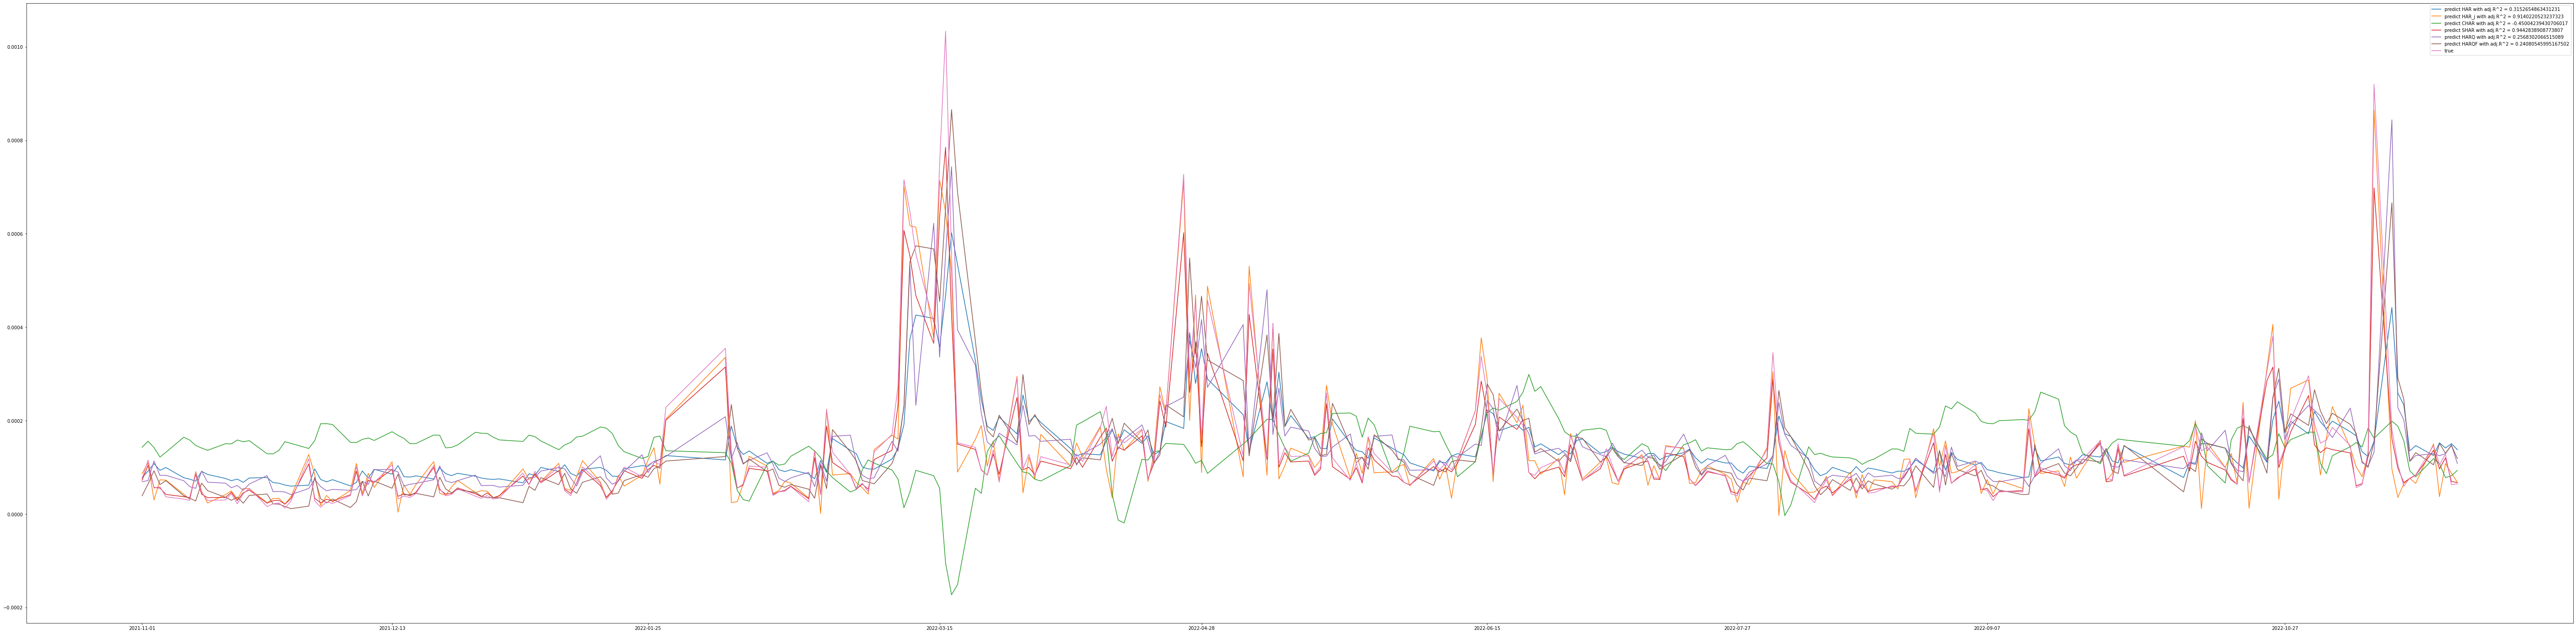

In [66]:
i = 0
names = ['HAR', 'HAR_j', 'CHAR', 'SHAR', 'HARQ', 'HARQF']

fig = plt.figure(figsize=(100, 25))
for df in [df_HAR, df_HAR_j, df_CHAR, df_SHAR, df_HARQ, df_HARQF]: #[x(returns, rv_per_day) for x in [HAR, HAR_j, CHAR, SHAR, HARQ]]:#, HARQF]]:
    features = [x for x in df.columns if (x != 'rv') & (x != 'date')]
    target = ['rv']
    #tscv = TimeSeriesSplit(n_splits = 4)
    #for train_index, test_index in tscv.split(df):
    #cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    param = 9 * df.shape[0]//10
    X_train = df[features][:param]
    y_train = df[target][:param]
    X_test = df[features][param:]
    y_test = df[target][param:]
    #print(df.shape, X_train.shape, X_test.shape)
    reg = LinearRegression().fit(X_train, y_train)
    coefficents = {}
    coef = reg.coef_[0]
    for ind, x in enumerate([x for x in coef]):
        coefficents[features[ind]] = x
    display(coefficents)
    plt.plot(df['date'][param:],reg.predict(X_test), label = 'predict ' + names[i] + ' with adj.R^2 = ' + str(1 - ((1 - r2_score(y_test, reg.predict(X_test))) * (y_test.shape[0] -1) / (y_test.shape[0] - len(features) -1))))
    if (i == 5):
    #text = str('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    
        #ax.set_title('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
        plt.plot(df['date'][param:],y_test, label = 'true')
        #plt.fill_between (df['date'][param:], y_test, color='black', alpha= .3 )
        plt.xticks(df['date'][param:][::30])
        plt.legend()
        plt.show()
    i +=1